# Dataset plot: t-SNE of dataset, proportion of tastes and molecular weight distribution

In [2]:
import pandas as pd
from rdkit import Chem 
from rdkit.Chem import AllChem, DataStructs, rdFingerprintGenerator

import numpy as np

fart_raw = pd.read_csv('/Users/lsieben/Desktop/FART-2.0/fart_curated.csv')

# Generate Tanimoto fingerprints from SMILES
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.nan  # Return NaN for invalid SMILES
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    fp = mfpgen.GetFingerprint(mol)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Calculate fingerprints for each SMILES in the dataframe
fart_raw['Fingerprint'] = fart_raw['Standardized SMILES'].apply(smiles_to_fingerprint)
fart_raw = fart_raw.dropna(subset=['Fingerprint'])  # Drop rows where fingerprints could not be calculated


[15:49:53] WARNING: not removing hydrogen atom without neighbors
[15:49:54] WARNING: not removing hydrogen atom without neighbors
[15:49:54] WARNING: not removing hydrogen atom without neighbors
[15:49:54] WARNING: not removing hydrogen atom without neighbors
[15:49:54] WARNING: not removing hydrogen atom without neighbors


## t-SNE plot with PCA initialization, Cosine metric, Morgan fingerprint 1024 bit

Standard deviation of embedding is greater than 0.0001. Initial embeddings with high variance may have display poor convergence.


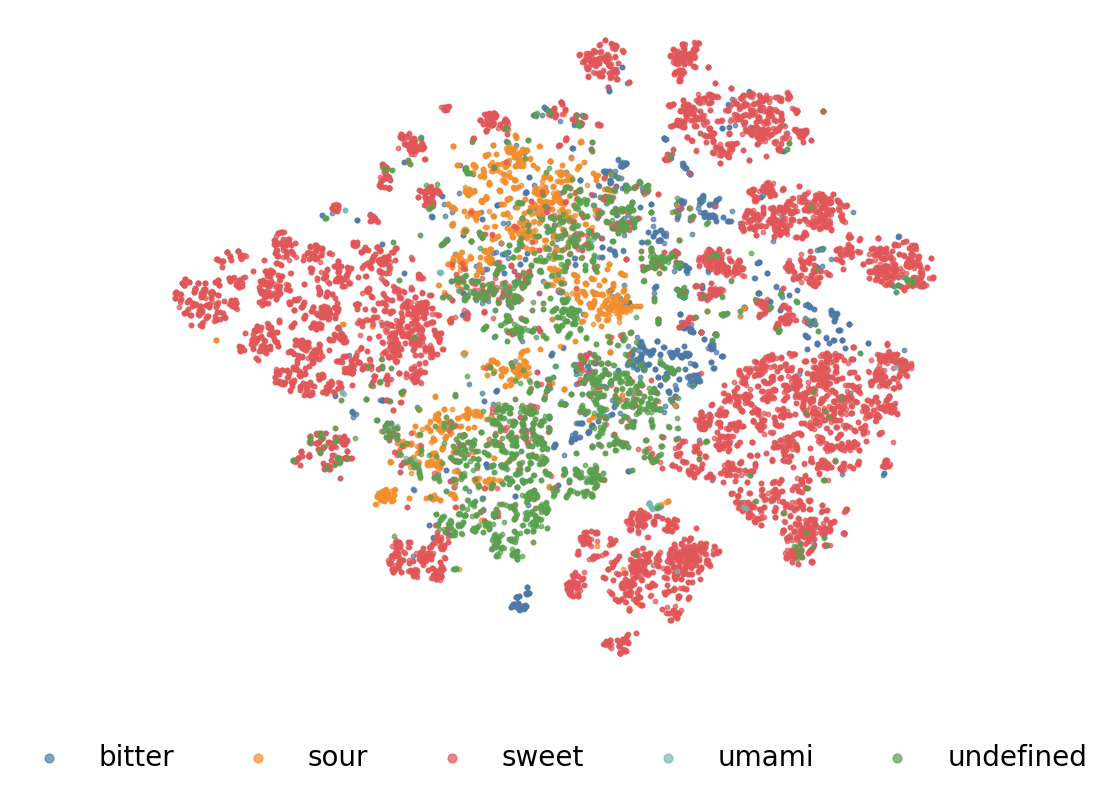

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE
from sklearn.decomposition import PCA

# Prepare data for t-SNE (stacking fingerprints into 2D array)
fingerprint_matrix = np.stack(fart_raw['Fingerprint'].values)

# Initialize with PCA for t-SNE
pca_init = PCA(n_components=2, random_state=42).fit_transform(fingerprint_matrix)

# Apply t-SNE for dimensionality reduction with PCA initialization
tsne_embedding = TSNE(
    n_components=2,
    perplexity=30,
    initialization=pca_init,
    random_state=777, 
    metric="cosine"
).fit(fingerprint_matrix)

# Add t-SNE results to the dataframe
fart_raw['tSNE-1'] = tsne_embedding[:, 0]
fart_raw['tSNE-2'] = tsne_embedding[:, 1]

# Define the color palette for taste categories
taste_colors = {
    'bitter': '#4E79A7',
    'sour': '#F28E2B',
    'sweet': '#E15759',
    'umami': '#76B7B2',
    'undefined': '#59A14F'
}

# Plot the t-SNE embedding with colors by taste class
plt.figure(figsize=(11, 8))
for taste, color in taste_colors.items():
    subset = fart_raw[fart_raw['Canonicalized Taste'] == taste]
    plt.scatter(subset['tSNE-1'], subset['tSNE-2'], s=10, color=color, label=taste, alpha=0.7)

# Remove the box, axis labels, and title
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])  # Remove x-axis labels
plt.yticks([])  # Remove y-axis labels

# Add the legend below the plot in a horizontal line
plt.legend(
    fontsize=20, 
    loc="upper center", 
    bbox_to_anchor=(0.5, -0.05),  # Position below the plot
    ncol=len(taste_colors),       # Arrange legend items in one row
    frameon=False,                 # Remove the frame around the legend
    scatterpoints=1,              # Use one marker in the legend
    markerscale=2                 # Scale up the marker size in the legend
)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("tSNE_PCA_Cosine_tastes.svg", format='svg')

plt.show()

## 

## Pie chart for label distribution

In [2]:

import pandas as pd

fart_raw = pd.read_csv('/Users/lsieben/Desktop/FART-2.0/fart_curated.csv')


In [12]:
taste_frequencies = fart_raw.groupby('Canonicalized Taste').size().to_dict()

# Prepare the dictionary for the pie chart
# Normalize keys to match the taste_frequencies keys
taste_categories = {
    'Bitter': taste_frequencies.get('bitter', 0),
    'Sour': taste_frequencies.get('sour', 0),
    'Sweet': taste_frequencies.get('sweet', 0),
    'Umami': taste_frequencies.get('umami', 0),
    'Undefined': taste_frequencies.get('undefined', 0),
}
taste_categories

{'Bitter': 1676, 'Sour': 1605, 'Sweet': 9542, 'Umami': 58, 'Undefined': 2150}

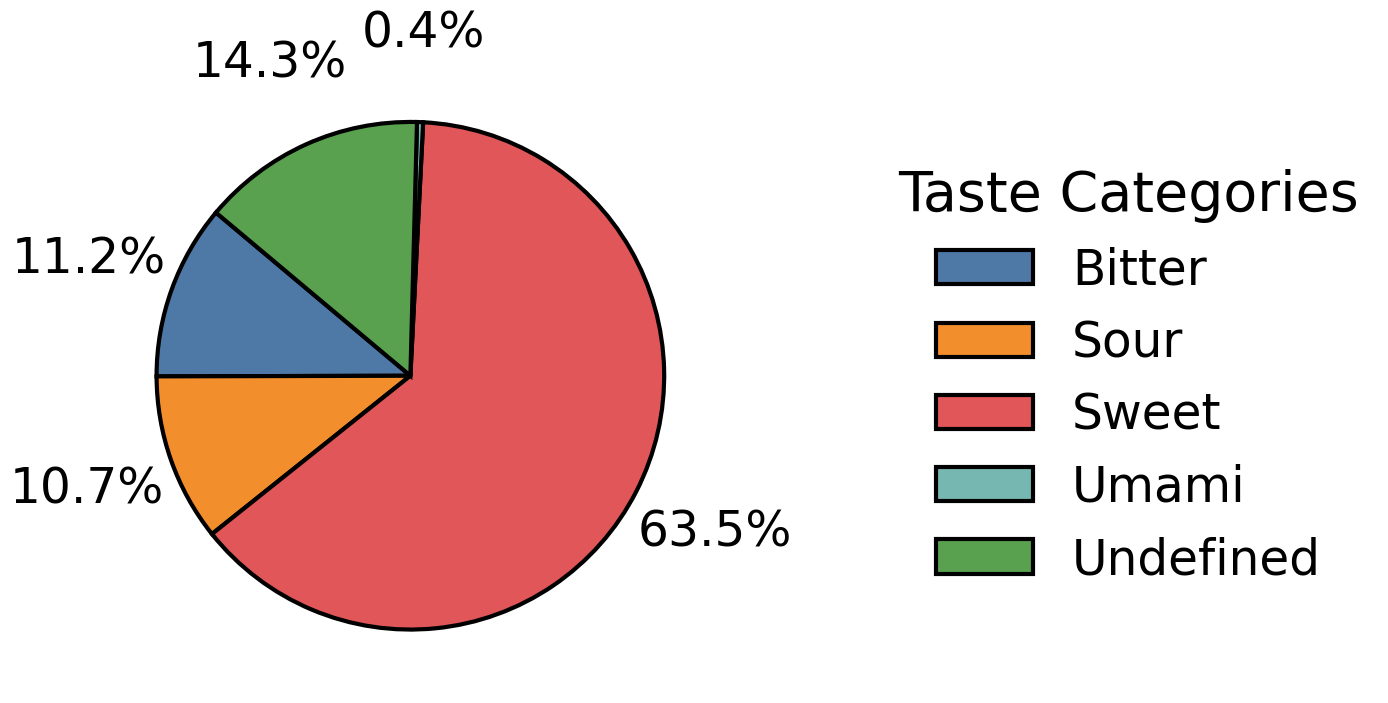

In [13]:
import matplotlib.pyplot as plt

# Calculate the frequency of each taste category
taste_frequencies = fart_raw.groupby('Canonicalized Taste').size().to_dict()

# Normalize keys to match the taste_frequencies keys
taste_categories = {
    'Bitter': taste_frequencies.get('bitter', 0),
    'Sour': taste_frequencies.get('sour', 0),
    'Sweet': taste_frequencies.get('sweet', 0),
    'Umami': taste_frequencies.get('umami', 0),
    'Undefined': taste_frequencies.get('undefined', 0),
}

colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']  # Subdued palette

# Plotting the pie chart
plt.figure(figsize=(15, 15))
wedges, texts, autotexts = plt.pie(
    taste_categories.values(),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=1.35,       # Position the percentage outside the slices
    labeldistance=1.3,      # Position the labels outside the slices
    textprops={'fontsize': 50},
    wedgeprops={'edgecolor': 'black', 'linewidth':3}
)

# Adjusting autotexts (percentages) for readability
for autotext in autotexts:
    autotext.set_fontsize(35)
    autotext.set_color('black')

# Adding a legend
plt.legend(
    wedges,
    taste_categories.keys(),
    title="Taste Categories",
    title_fontsize=40,  # Setting the legend title font size
    loc="center left",
    bbox_to_anchor=(1.2, 0, 0.5, 1),  # Moving the legend farther to the right
    fontsize=35, 
    frameon=False
)

# Title and layout adjustments
#plt.title('Proportion of Taste Categories', fontsize=16)
plt.tight_layout()

# Save as an EPS file for Overleaf
plt.savefig("proportion_of_data_sources-with-percentages.svg", format='svg')

plt.show()


## Molecular weight distribution

In [14]:
from rdkit.Chem import Descriptors

# Calculate molecular weights based on SMILES
fart_raw['MolecularWeight'] = fart_raw['Canonicalized SMILES'].apply(
    lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) else None
)

[15:56:36] WARNING: not removing hydrogen atom without neighbors
[15:56:36] WARNING: not removing hydrogen atom without neighbors
[15:56:36] WARNING: not removing hydrogen atom without neighbors
[15:56:36] WARNING: not removing hydrogen atom without neighbors
[15:56:37] WARNING: not removing hydrogen atom without neighbors
[15:56:37] WARNING: not removing hydrogen atom without neighbors
[15:56:37] WARNING: not removing hydrogen atom without neighbors
[15:56:37] WARNING: not removing hydrogen atom without neighbors
[15:56:37] WARNING: not removing hydrogen atom without neighbors
[15:56:37] WARNING: not removing hydrogen atom without neighbors


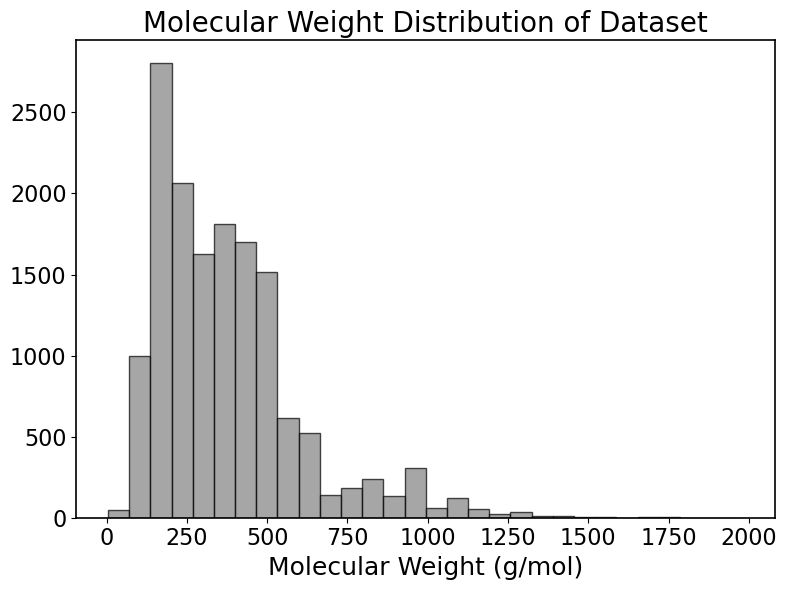

In [ ]:
# Plotting the molecular weight distribution
plt.figure(figsize=(8, 6))
plt.hist(fart_raw['MolecularWeight'], bins=30, color='gray', edgecolor='black', alpha=0.7)

# Set plot aesthetics for an academic journal
plt.xlabel('Molecular Weight (g/mol)', fontsize=18)
#plt.ylabel('Frequency', fontsize=18)
plt.title('Molecular Weight Distribution of Dataset', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Calculate mean and standard deviation of molecular weight
mean_mw = fart_raw['MolecularWeight'].mean()
std_mw = fart_raw['MolecularWeight'].std()

plt.grid(visible=False, axis='y')

# Make the box outlines thicker
ax = plt.gca()  # Get the current axes
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Tight layout for better spacing
plt.tight_layout()

plt.savefig("MW-Distribution.svg", format='svg')

# Show the plot
plt.show()